# Summary
データセットをセットアップして，津山高専北館分類器を組む．その後テストセットでの精度を測る．  
考察・改善はモデル生成後に行う．

## データセット生成

In [17]:
from PIL import Image
import tempfile, glob
import random, math
import numpy as np

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump"
DATASET_DIR = DUMP_DIR + "/labeled"
LABEL_NAME = ['not_north', 'north']

def make_npdatasets(image_files):
    X = []
    y = []
    for label, image_file in image_files:
        # append to X, y
        X.append(make_npimage(image_file))
        y.append(label)
    return np.array(X), np.array(y)

def make_npimage(image_file):
    RESIZE_VAL = 150 # resized by 150
    image = Image.open(image_file)
    image = image.convert("RGB")
    image = image.resize((RESIZE_VAL, RESIZE_VAL))
    return np.asarray(image) # return image array

def main():
    datasets_array = []

    for i, label in enumerate(LABEL_NAME):
        image_dir = DATASET_DIR + "/" + label
        image_files = glob.glob(image_dir + "/*.jpg")
        for image_file in image_files:
            datasets_array.append((i, image_file))

    # shuffle datasets
    random.shuffle(datasets_array)
    train_size = math.floor(len(datasets_array) * 0.7)
    X_train, y_train = make_npdatasets(datasets_array[0:train_size])
    X_test, y_test = make_npdatasets(datasets_array[train_size:])

    # save dataset array
    xy = (X_train, X_test, y_train, y_test)
    np.save(DUMP_DIR + "/north_datasets.npy", xy)

if __name__ == "__main__":
    main()


## CNNによる分類

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

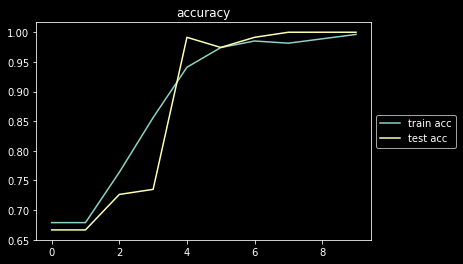

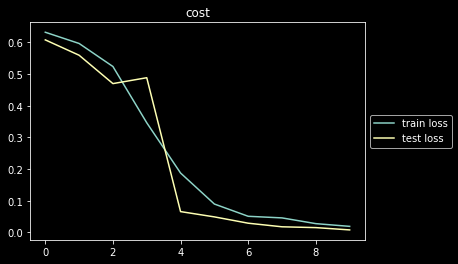

In [21]:
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump"
DATASET_DIR = os.getenv('HOME') + "/teraken_overtime_dump/labeled"
LABEL_NAME = ['not_north', 'north']

%matplotlib inline

def create_model():
    RESIZE_VAL = 150 # resized by 150
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(RESIZE_VAL, RESIZE_VAL, 3))) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Conv2D(64, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Conv2D(128, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Conv2D(128, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Flatten()) # flatten layer
    model.add(layers.Dense(512, activation="relu")) # fully connect layer 1
    model.add(layers.Dense(1, activation="sigmoid")) # fully connect layer 2 (output)

    model.summary() # show summary

    model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["acc"]) # compile model
    return model

def train_model(model, datasets_path):
    X_train, X_test, y_train, y_test = np.load(datasets_path)
    X_train = X_train.astype("float") / 255
    X_test  = X_test.astype("float")  / 255
    model_stack = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_test, y_test))
    return model_stack

def show_history(model_stack):
    acc = model_stack.history['acc']
    val_acc = model_stack.history['val_acc']
    loss = model_stack.history['loss']
    val_loss = model_stack.history['val_loss']

    # plot learning curve
    epoch = range(len(acc))
    plt.style.use('dark_background')
    plt.plot(epoch, acc, label="train acc")
    plt.plot(epoch, val_acc, label="test acc")
    plt.title("accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot(epoch, loss, label='train loss')
    plt.plot(epoch, val_loss, label='test loss')
    plt.title('loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def main():
    datasets_path = DUMP_DIR + "/north_datasets.npy"
    model = create_model()

    model_stack = train_model(model, datasets_path) # training model
    show_history(model_stack)

    # save model
    model_string = model.to_json()
    open(DUMP_DIR + "/north_model_cnn.json", 'w').write(model_string)

    # save parameter
    model.save_weights(DUMP_DIR + "/north_params_cnn.hdf5")

if __name__ == "__main__":
    main()


## CNNによる分類の考察
現時点ではtrain loss, test loss共に大体epoch毎に下がっているため悪くないと考えられる．  
2-4epochでtest lossが一度上がっている点が少し気になるくらい?

データセットが2日程度しか無いため，同日中の天候などからデータが偏っていることが想定される(7/13現在)．  
画像変換による天候の差分生成 or もう数日のデータを集めることが必要(評価データのことを考えると数日待つ方が良い)．

## ロジスティック回帰による分類

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_14 (Lambda)           (None, 150, 150)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 22501     
Total params: 22,501
Trainable params: 22,501
Non-trainable params: 0
_________________________________________________________________
Train on 271 samples, validate on 117 samples
Epoch 1/10
271/271 [==============================] - 1s 3ms/step - loss: 3.3202 - acc: 0.6642 - val_loss: 3.9944 - val_acc: 0.6667
Epoch 2/10
271/271 [==============================] - 0s 1ms/step - loss: 1.2392 - acc: 0.8339 - val_loss: 0.0525 - val_acc: 0.9658
Epoch 3/10
271/271 [==============================] - 0s 1ms/step - loss: 0.0497 - acc: 0.98

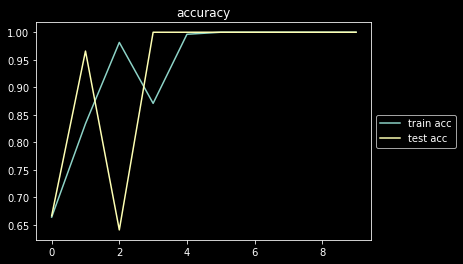

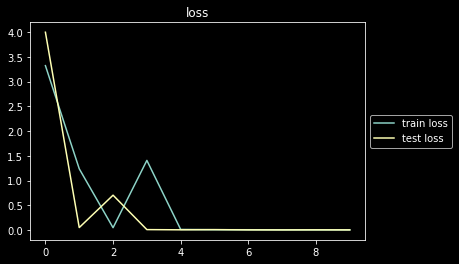

In [39]:
from keras import layers, models, backend
import numpy as np
import matplotlib.pyplot as plt
import os

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump"
DATASET_DIR = os.getenv('HOME') + "/teraken_overtime_dump/labeled"
LABEL_NAME = ['not_north', 'north']

%matplotlib inline

def to_grayscale(X):
    L_FILTER = backend.constant([[[[0.21 , 0.72 , 0.07]]]])
    return backend.sum(X * L_FILTER, axis=-1, keepdims=False)

def create_model():
    RESIZE_VAL = 150 # resized by 150
    model = models.Sequential()
    model.add(layers.Lambda(to_grayscale, input_shape=(RESIZE_VAL, RESIZE_VAL, 3)))
    model.add(layers.Flatten()) # flatten layer
    model.add(layers.Dense(1, activation="sigmoid")) # logistic regression (output)

    model.summary() # show summary

    model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["acc"]) # compile model
    return model

def train_model(model, datasets_path):
    X_train, X_test, y_train, y_test = np.load(datasets_path)
    X_train = X_train.astype("float") / 255
    X_test  = X_test.astype("float")  / 255
    model_stack = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_test, y_test))
    return model_stack

def show_history(model_stack):
    acc = model_stack.history['acc']
    val_acc = model_stack.history['val_acc']
    loss = model_stack.history['loss']
    val_loss = model_stack.history['val_loss']

    # plot learning curve
    epoch = range(len(acc))
    plt.style.use('dark_background')
    plt.plot(epoch, acc, label="train acc")
    plt.plot(epoch, val_acc, label="test acc")
    plt.title("accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot(epoch, loss, label='train loss')
    plt.plot(epoch, val_loss, label='test loss')
    plt.title('loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def main():
    datasets_path = DUMP_DIR + "/north_datasets.npy"
    model = create_model()

    model_stack = train_model(model, datasets_path) # training model
    show_history(model_stack)

    # save model
    model_string = model.to_json()
    open(DUMP_DIR + "/north_model_logistic.json", 'w').write(model_string)

    # save parameter
    model.save_weights(DUMP_DIR + "/north_params_logistic.hdf5")

if __name__ == "__main__":
    main()


## ロジスティック回帰による分類の考察
現時点では驚くべきことに精度がとても良い．  
グレースケール変換によってすべての画像を同じ色空間で比較できるようになった点が影響しているかもしれない(夜間の画像はグレースケールに変換して出力されている)．  

3-4epochあたりでtrain lossが上がったのはcrossentropyを使用しているためか?  

現時点では精度が良いが，まだデータセットに日付の偏りがあるためそれを解消した上で再出力させて見る必要がある．